**Кузина Екатерина**  
**Задание 4. Алгоритм LLE**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial import KDTree

class LLE:
    def __init__(self, n_neighbors: int = 5, n_components: int = 2):
        self.n_neighbors = n_neighbors
        self.n_components = n_components

    def fit_transform(self, X: np.ndarray = [], remove_zero: bool = True):
        n_samples = X.shape[0]
        W = np.zeros([n_samples, n_samples])
        adjacency_index_matrix = self._construct_graph(X)
        for idx in range(n_samples):
            Z = X[adjacency_index_matrix[idx, :], :]
            Zi = Z - X[idx, :]
            covariance_matrix = Zi @ Zi.T
            wi = np.linalg.pinv(covariance_matrix) @ np.ones([self.n_neighbors, 1]) / \
                 np.sum(np.linalg.pinv(covariance_matrix))
            for jdx in range(self.n_neighbors):
                W[adjacency_index_matrix[idx, jdx], idx] = wi[jdx]

        M = (np.eye(n_samples) - W) @ (np.eye(n_samples) - W).T
        eigen_vector, eigen_value, vT = np.linalg.svd(M)
        X_embedded = eigen_vector[:, -self.n_components - 1:-1]
        
        return X_embedded
    
    def _construct_graph(self, X: np.ndarray):
        n_samples = X.shape[0]
        kd_tree = KDTree(X.copy())
        adjacency_index_matrix = np.ones([n_samples, self.n_neighbors], dtype=int)
        for idx in range(n_samples):
            _, neighbors = kd_tree.query(X[idx, :], k=self.n_neighbors + 1, p=2)
            neighbors = neighbors.tolist()
            neighbors.remove(idx)
            adjacency_index_matrix[idx, :] = np.array([neighbors])

        return adjacency_index_matrix

In [ ]:
from sklearn.datasets import make_swiss_roll
from sklearn.cluster import AgglomerativeClustering

X, _ = make_swiss_roll(1000, noise=0, random_state=0)
ward = AgglomerativeClustering(n_clusters=8, linkage='ward').fit(X)
label = ward.labels_

lle = LLE(12, 2)
x_lle = lle.fit_transform(X)

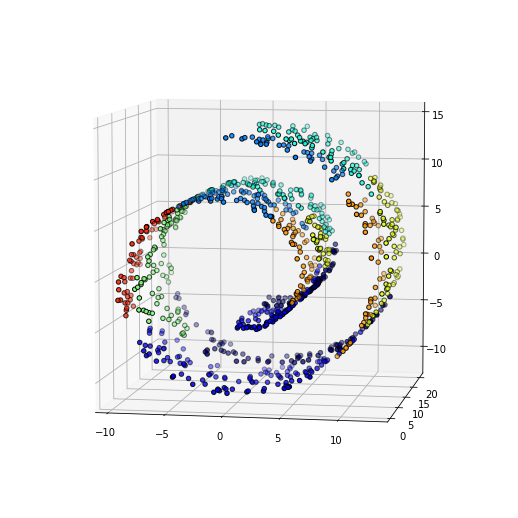

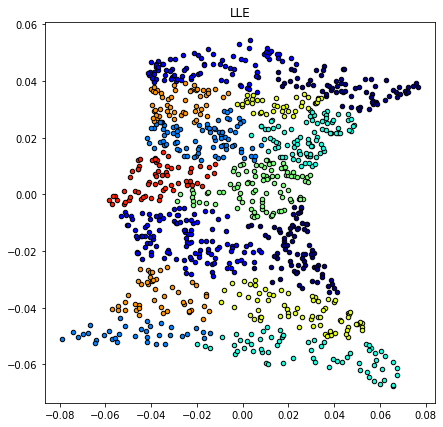

In [ ]:
import mpl_toolkits.mplot3d.axes3d as p3

fig = plt.figure(figsize=(7, 7))
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
    
plt.figure(figsize=(7, 7))
plt.title("LLE")
for l in np.unique(label):
    plt.scatter(x_lle[label == l, 0], x_lle[label == l, 1],
                color=plt.cm.jet(float(l) / np.max(label + 1)),
                s=20, edgecolor='k')

**БОНУС. Алгоритм Hessian LLE**

In [ ]:
class HessianLLE:
    def __init__(self, n_neighbors: int = 5, n_components: int = 2):
        self.n_neighbors = n_neighbors
        self.n_components = n_components

    def fit_transform(self, X: np.ndarray = []):
        n_samples = X.shape[0]
        dp = self.n_components * (self.n_components + 1) // 2

        if self.n_neighbors <= self.n_components + dp:
            raise ValueError("for hessian lle n_neighbors must be "
                             "greater than "
                             "[n_components * (n_components + 3) / 2]")
            
        adjacency_index_matrix = self._construct_graph(X)
        W = np.zeros((dp * n_samples, n_samples))
        Yi = np.empty((self.n_neighbors, self.n_components + dp + 1))
        Yi[:, 0] = 1
        for i in range(n_samples):
            neighbors_i = adjacency_index_matrix[i, :]
            Gi = X[neighbors_i]
            Gi -= Gi.mean(0)

            U = np.linalg.svd(Gi, full_matrices=0)[0]

            Yi[:, 1:1 + self.n_components] = U[:, :self.n_components]
            j = 1 + self.n_components
            for k in range(self.n_components):
                Yi[:, j:j + self.n_components - k] = (U[:, k:k + 1] *
                                                      U[:, k:self.n_components])
                j += self.n_components - k

            Q, R = np.linalg.qr(Yi)
            w = np.array(Q[:, self.n_components+1:])
            S = w.sum(0)

            S[np.where(np.abs(S) < 1e-5)] = 1.
            w /= S
            neighbors_x, neighbors_y = np.meshgrid(neighbors_i, neighbors_i)
            W[neighbors_x, neighbors_y] += w @ w.T

        _, sig, VT = np.linalg.svd(W, full_matrices=0)
        idx = np.argsort(sig)[1:self.n_components + 1]
        Y = VT[idx, :] * np.sqrt(n_samples)

        _, sig, VT = np.linalg.svd(Y, full_matrices=0)
        S = np.matrix(np.diag(sig ** (-1)))
        R = VT.T * S * VT

        return np.array(Y * R).T
    
    def _construct_graph(self, X: np.ndarray):
        n_samples = X.shape[0]
        kd_tree = KDTree(X.copy())
        adjacency_index_matrix = np.ones([n_samples, self.n_neighbors], dtype=int)
        for idx in range(n_samples):
            _, neighbors = kd_tree.query(X[idx, :], k=self.n_neighbors + 1, p=2)
            neighbors = neighbors.tolist()
            neighbors.remove(idx)
            adjacency_index_matrix[idx, :] = np.array([neighbors])
            
        return adjacency_index_matrix

In [ ]:
hlle = HessianLLE(n_neighbors=12, n_components=2)
x_hlle = hlle.fit_transform(X)

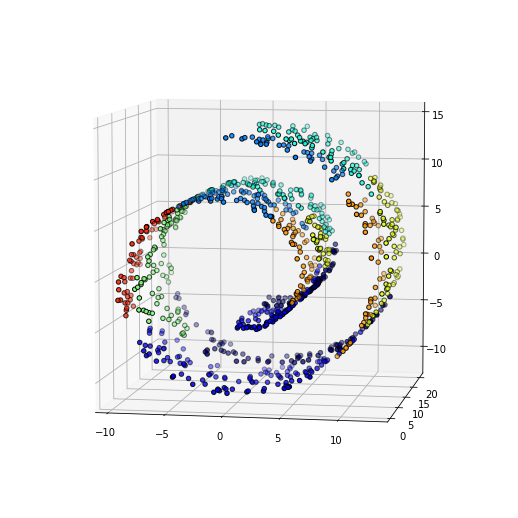

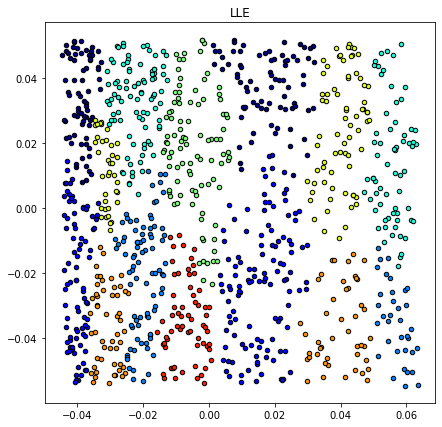

In [ ]:
import mpl_toolkits.mplot3d.axes3d as p3

fig = plt.figure(figsize=(7, 7))
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
    
plt.figure(figsize=(7, 7))
plt.title("LLE")
for l in np.unique(label):
    plt.scatter(x_hlle[label == l, 0], x_hlle[label == l, 1],
                color=plt.cm.jet(float(l) / np.max(label + 1)),
                s=20, edgecolor='k')